### Chapter 7: Dynamic Time Warping

In [1]:
# import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastdtw import fastdtw
from keypoints import pose
from scipy.signal import medfilt
from scipy.spatial.distance import euclidean

In [2]:
# create a function that loads some sample data
def load_features(names):
    output = [] 
    for filename in names:
        ps = pose.PoseSequence.load('data/dtw/sample/' + filename)
        poses = ps.poses

        right_present = [1 for pose in poses if pose.rshoulder.exists and pose.relbow.exists and pose.rwrist.exists]
        left_present = [1 for pose in poses if pose.lshoulder.exists and pose.lelbow.exists and pose.lwrist.exists]
        right_count = sum(right_present)
        left_count = sum(left_present)
        side = 'right' if right_count > left_count else 'left'

        if side == 'right':
            joints = [(pose.rshoulder, pose.relbow, pose.rwrist, pose.rhip, pose.neck) for pose in poses]
        else:
            joints = [(pose.lshoulder, pose.lelbow, pose.lwrist, pose.lhip, pose.neck) for pose in poses]

        # filter out data points where a part does not exist
        joints = [joint for joint in joints if all(part.exists for part in joint)]
        
        upper_arm_vecs = np.array([(joint[0].x - joint[1].x, joint[0].y - joint[1].y) for joint in joints])
        forearm_vecs = np.array([(joint[2].x - joint[1].x, joint[2].y - joint[1].y) for joint in joints])
        
        upper_arm_vecs = upper_arm_vecs / np.expand_dims(np.linalg.norm(upper_arm_vecs, axis=1), axis=1)
        forearm_vecs = forearm_vecs / np.expand_dims(np.linalg.norm(forearm_vecs, axis=1), axis=1)
        
        upper_arm_forearm_angle = np.degrees(np.arccos(np.clip(np.sum(np.multiply(upper_arm_vecs, forearm_vecs), axis=1), -1.0, 1.0)))
        upper_arm_forearm_angle_filtered = medfilt(medfilt(upper_arm_forearm_angle, 5), 5)

        output.append(upper_arm_forearm_angle_filtered.tolist())
    return output

In [3]:
# load the data
data = load_features(['x.npy', 'y.npy'])

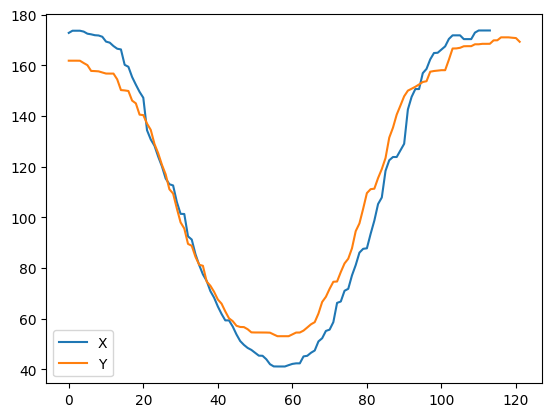

In [4]:
# separate the data points and plot them
x = data[0]
y = data[1]
plt.plot(x, label='X')
plt.plot(y, label='Y')
plt.legend()
plt.show()

In [5]:
# calulate the distance and path between x and y using Dynamic Time Warping
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

488.70072893464635


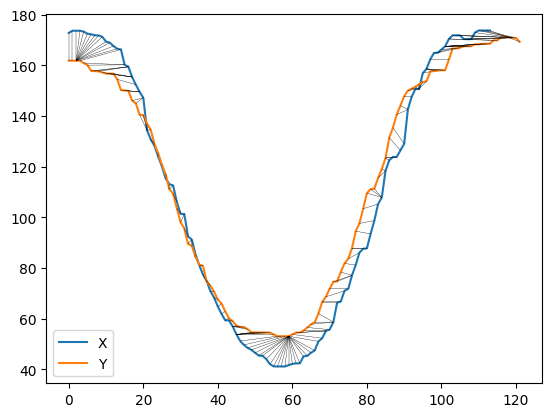

In [6]:
# plot the connections between x and y points
plt.plot(x, label='X')
plt.plot(y, label='Y')
for [map_x, map_y] in path:
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'k', linewidth=0.25)
plt.legend()
plt.show()